In [1]:
# horse, 792

In [2]:
from tqdm.notebook import tqdm
import datetime
import dpkt
import numpy as np
import matplotlib.pyplot as plt
import os
import open3d as op3 
import seaborn as sns
import pandas as pd
from scipy import ndimage as ndi
import time

In [3]:
class LidarLoader():
    def __init__(self,file_path): 
        self.Data_order = np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
                                    [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
                                    [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
                                    [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
                                    [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
                                    [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
                                    [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
                                    [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
                                    ])
        self.timing_offset = self.calc_timing_offsets()
        self.omega = self.Data_order[:,0]
        self.lidar_reader = 0
        self.file_path = file_path
        self.load_reader()
        
    def load_reader(self):
        try:
            fpcap = open(self.file_path, 'rb')
            self.lidar_reader = dpkt.pcap.Reader(fpcap)
        except Exception as ex:
            print(str(ex))

    def read_uint32(self,data, idx):
        return data[idx] + data[idx+1]*256 + data[idx+2]*256*256 + data[idx+3]*256*256*256
    def read_firing_data(self,data):
        block_id = data[0] + data[1]*256
        azimuth = (data[2] + data[3] * 256) / 100 # degree
        firings = data[4:].reshape(32, 3) 
        distances = firings[:, 0] + firings[:, 1] * 256 # mm 
        intensities = firings[:, 2] # 0-255
        return distances, intensities, azimuth #(1,0)
        
    def calc_timing_offsets(self):
        timing_offsets = np.zeros((32,12))  # Init matrix
        # constants
        full_firing_cycle = 55.296  # μs
        single_firing = 2.304  # μs
        # compute timing offsets
        for x in range(12):
            for y in range(32):
                dataBlockIndex = (x * 2) + int((y / 16))
                dataPointIndex = y % 16
                timing_offsets[y][x] = (full_firing_cycle * dataBlockIndex) +(single_firing * dataPointIndex)
        return np.array(timing_offsets).T

    def calc_precise_azimuth(self,azimuth):

        # block_number: how many blocks are required to be processed 

        org_azi = azimuth.copy()
        precision_azimuth = []
        # iterate through each block
        for n in range(len(org_azi)): # n=0..11
            azimuth = org_azi.copy()
            try:
                # First, adjust for an Azimuth rollover from 359.99° to 0°
                if azimuth[n + 1] < azimuth[n]:
                    azimuth[n + 1] += 360

                # Determine the azimuth Gap between data blocks
                azimuth_gap = azimuth[n + 1] - azimuth[n]
            except:
                if azimuth[n] < azimuth[n-1]:
                    azimuth[n] += 360
                azimuth_gap = azimuth[n] - azimuth[n-1]

            factor = azimuth_gap / 32.
            k = np.arange(32)
            precise_azimuth = azimuth[n] + factor * k
            precision_azimuth.append(precise_azimuth)

        precision_azimuth = np.array(precision_azimuth)
        return precision_azimuth # 12 * 32

    def calc_cart_coord(self,distances, azimuth):# distance: 12*32 azimuth: 12*32
        # convert deg to rad
        longitudes = self.omega * np.pi / 180.
        latitudes = azimuth * np.pi / 180.

        hypotenuses = distances * np.cos(longitudes)

        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = distances * np.sin(longitudes)
        return X, Y, Z
    

    def parse_one_packet(self,data):
        data = np.frombuffer(data, dtype=np.uint8).astype(np.uint32)
        blocks = data[0:1200].reshape(12, 100)
        # Timestamp = self.read_uint32(data[1200:1204],0)
        distances = []#12*32
        intensities = []#12*32
        azimuth_per_block = [] #(12,0)
        # iteratie through each block
        for i, blk in enumerate(blocks):
            dists, intens, angles = self.read_firing_data(blk)
            distances.append(dists) #12*32
            intensities.append(intens) #12*32
            azimuth_per_block.append(angles)

        azimuth_per_block = np.array(azimuth_per_block)
        distances = np.array(distances)*4/1000 # 12*32
        intensities = np.array(intensities) # 12*32

        return distances,intensities, azimuth_per_block # 12*0
 
    
    def gen_td_map(self,frame):
        
        azimuth_ind = np.around(frame[:,0]/0.2).astype('int')
        azimuth_ind[azimuth_ind == 1800] = 0
        theta_ind = frame[:,-1].astype('int')
        td_freq_map = np.zeros((1800,32))
        td_freq_map[azimuth_ind,theta_ind] = frame[:,1]
        return td_freq_map
    
    def cal_angle_diff(self,advance_angle,lagging_angle):
        if advance_angle < lagging_angle:
            return advance_angle + 360 - lagging_angle
        else:
            return advance_angle - lagging_angle
    
    def frame_gen(self):
        initial_azimuth = -1
        cur_azimuth = -1
        culmulative_azimuth = 0
        block_num = 0
        
        while True:
            frame = []
            for ts,buf in self.lidar_reader:
                
                eth = dpkt.ethernet.Ethernet(buf)
                data = eth.data.data.data
                packet_status = eth.data.data.sport
                if packet_status == 2368:
                    if len(data)<1206:
                        continue
                    distances,intensities,azimuth_per_block = self.parse_one_packet(data)
                    
                    azimuth = self.calc_precise_azimuth(azimuth_per_block) # 12*32
                    azimuth += self.Data_order[:,1]
                    if initial_azimuth == -1: #initialization
                        initial_azimuth = azimuth_per_block[0]
                        cur_azimuth = azimuth_per_block[-1]
                        frame.append(np.concatenate([azimuth.flatten().reshape(-1,1),
                                                     distances.flatten().reshape(-1,1),
                                                     intensities.flatten().reshape(-1,1)],axis = 1))
                        block_num += 12
                        culmulative_azimuth += self.cal_angle_diff(azimuth_per_block[-1],azimuth_per_block[0])
                    else:# non-initialization
                        diff = self.cal_angle_diff(azimuth_per_block[-1],cur_azimuth)
                        temp_culmulative_azimuth = culmulative_azimuth + diff 
                        
                        if temp_culmulative_azimuth > 360: 
                            
                            frame_end_index = 0
                            for i in range(len(azimuth_per_block)):
                                diff = self.cal_angle_diff(azimuth_per_block[i],cur_azimuth)                                
                                temp_culmulative_azimuth = culmulative_azimuth + diff
                                if temp_culmulative_azimuth > 360:
                                    frame_end_index = i 
                                    break 
                                else:
                                    block_num += 1
                                    cur_azimuth = azimuth_per_block[i]
                                    culmulative_azimuth = temp_culmulative_azimuth
                                    
                            frame.append(np.concatenate([azimuth[:frame_end_index].flatten().reshape(-1,1),
                                                         distances[:frame_end_index].flatten().reshape(-1,1),
                                                         intensities[:frame_end_index].flatten().reshape(-1,1)],axis = 1))
                            temp = np.concatenate(frame)
                            theta_ind = np.tile(np.arange(32),block_num).reshape(-1,1)
                            temp[:,0][temp[:,0]>360] -= 360
                            temp[:,0][temp[:,0]<0] += 360
                            temp = np.concatenate([temp,theta_ind],axis = 1)
                            frame = []
                            block_num = 12 - frame_end_index  
                            cur_azimuth = azimuth_per_block[-1]
                            diff = self.cal_angle_diff(azimuth_per_block[-1],azimuth_per_block[frame_end_index])                    
                            culmulative_azimuth = diff
                            frame.append(np.concatenate([azimuth[frame_end_index:].flatten().reshape(-1,1),
                                                         distances[frame_end_index:].flatten().reshape(-1,1),
                                                         intensities[frame_end_index:].flatten().reshape(-1,1)],axis = 1))
                            td_freq_map = self.gen_td_map(temp)
                            
                            yield td_freq_map #32*1800
                            
                        else:
                            culmulative_azimuth = temp_culmulative_azimuth
                            frame.append(np.concatenate([azimuth.flatten().reshape(-1,1),
                                                         distances.flatten().reshape(-1,1),
                                                         intensities.flatten().reshape(-1,1)],axis = 1))
                            cur_azimuth = azimuth_per_block[-1]
                            block_num += 12
                        

In [4]:
theta = np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
                                    [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
                                    [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
                                    [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
                                    [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
                                    [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
                                    [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
                                    [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
                                    ])[:,0]

In [5]:
os.getcwd()

'/Users/czhui960/Documents/Lidar/Lidar_Code'

In [10]:
file_path  = r'../to ZHIHUI/USA pkwy/2019-12-18-10-0-0.pcap'
lidar_reader = LidarLoader(file_path)
frame_gen = lidar_reader.frame_gen()
td_maps = [] 
for i in tqdm(range(5000)):
    one_frame = next(frame_gen)
    td_maps.append(one_frame)
aggregated_maps = np.array(td_maps)
aggregated_maps_sorted = aggregated_maps[:,:,theta.argsort()]

In [11]:
def count(TSAv):
    temp_count = 0
    apear_ind = []
    counts = []
    for i in range(len(TSAv)):
        if (TSAv[i] == True):
            temp_count += 1
        else:
            if (i > 0) & (TSAv[i - 1] == True):
                apear_ind.append(i - temp_count)
                counts.append(temp_count)
                temp_count = 0
                counts.append(0)
            else:
                counts.append(0)
        if (i == len(TSAv) - 1) & (temp_count != 0):
            apear_ind.append(i - temp_count + 1)
            counts.append(temp_count)
    counts = np.array(counts)
    counts = counts[counts > 0]
    return np.array(counts), np.array(apear_ind)

In [12]:
def gen_frame_pcd(td_freq_map):
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(td_freq_map.shape[0]):
        longitudes = np.sort(theta)*np.pi / 180
        latitudes = i*0.2* np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        # 0 refers to background
        Xs.append(X)
        Ys.append(Y)
        Zs.append(Z)
    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    pcd = op3.geometry.PointCloud()
    pcd.points = op3.utility.Vector3dVector(np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1))
    return pcd
                

In [13]:
def get_threshold(ts):
    ts_temp = ts.copy()
    if (len(ts_temp[ts_temp >= 200])/len(ts_temp) )>0.9:
        return 200
    ts_temp = ts_temp[ts_temp < 200]
    max_ts_temp,min_ts_temp = ts_temp.max(),ts_temp.min()
    if (max_ts_temp - min_ts_temp)<2:
        return min_ts_temp
    steps = np.arange(min_ts_temp,max_ts_temp,0.02)
    maximum_dis = []
    for step in steps:
        try:
            upper = ts_temp[ts_temp>step]
            down = ts_temp[ts_temp<=step]
            if len(down)>len(upper):
                break
            upper_min = upper.min()
            down_min = down.min()
            maximum_dis.append(upper_min - down_min)
        except:
            continue
    counts_temp,appears = count((np.diff(maximum_dis) == 0).tolist())
    counts_temp_index = np.where(counts_temp>75)[0]###
    dises = []
    for i in range(len(counts_temp_index)):
        dises.append(steps[appears[counts_temp_index[i]]])
    if len(dises) == 0:
        return min_ts_temp
    else:
        thred = steps[appears[counts_temp_index[np.argmax(dises)]]+counts_temp[counts_temp_index[np.argmax(dises)]]]
        return thred

In [14]:
def find_undetected_neighbors(pixel_coord,tattoo_map):
    neighbors = []
    temp = pixel_coord.copy()
    if temp[0] != (tattoo_map.shape[0] - 1) and temp[1] != (tattoo_map.shape[1] -1):
        down_right = np.array([[temp[0]+1,temp[1] + 1]])
        neighbors.append(down_right)
    if temp[0] != (tattoo_map.shape[0] - 1) and temp[1] != 0:
        down_left = np.array([[temp[0]+1,temp[1]-1]]) 
        neighbors.append(down_left)
    if temp[0] != (tattoo_map.shape[0] - 1):
        down = np.array([[temp[0]+1,temp[1]]])
        neighbors.append(down)
    if temp[1] != 0:
        left = np.array([[temp[0], temp[1] - 1]])
        neighbors.append(left)
    if temp[1] != (tattoo_map.shape[1] - 1):
        right = np.array([[temp[0],temp[1] + 1]])
        neighbors.append(right)
    if temp[0] != 0 and temp[1] != 0:
        upper_left = np.array([[temp[0] - 1,temp[1] - 1]])
        neighbors.append(upper_left)
    if temp[0] != 0:
        upper = np.array([[temp[0] - 1, temp[1]]])
        neighbors.append(upper)
    if temp[0] != 0 and temp[1] != (tattoo_map.shape[1] - 1):
        upper_right = np.array([[temp[0] - 1, temp[1] + 1]])
        neighbors.append(upper_right)
    
    neighbors = np.concatenate(neighbors)
    available_point_index = []
    for i in range(len(neighbors)):
        if tattoo_map[neighbors[i][0],neighbors[i][1]] != 1:
            available_point_index.append(i)
    return neighbors[available_point_index]

In [15]:
def get_initial_tattoo_table(aggregated_maps_sorted_temp,threshold_map):
    searching_tatoo_table = np.zeros((aggregated_maps_sorted_temp.shape[1],aggregated_maps_sorted_temp.shape[2]))
    for i in tqdm(range(aggregated_maps_sorted_temp.shape[1])):
        for j in range(aggregated_maps_sorted_temp.shape[2]):
            t_s = aggregated_maps_sorted_temp[:,i,j].copy()
            threshold_value = threshold_map[i,j]
            if (t_s<threshold_value).sum() == 0:                
                # 1 refers to the beam is the static background, no need to search here
                searching_tatoo_table[i,j] = int(1)
    return searching_tatoo_table

In [17]:
aggregated_maps_sorted_temp = aggregated_maps_sorted.copy()
for i in tqdm(range(1800)):
    for j in range(32):
        ts_b = aggregated_maps_sorted_temp[:,i,j].copy()
        median = np.median(ts_b)
        ts_b[ts_b == 0] = median
        ts_b[ts_b == 0] = 200
        aggregated_maps_sorted_temp[:,i,j] = ts_b

In [18]:
threshold_map = np.zeros((1800,32))
for i in tqdm(range(1800)):
    for j in range(32):
        t_s = aggregated_maps_sorted_temp[:,i,j].copy()
        threshold_value = get_threshold(t_s)
        threshold_map[i,j] = threshold_value

In [25]:
if 'Calibration File' not in os.listdir(os.getcwd()):
    os.mkdir('Calibration File')
np.save(r'./Calibration File/threshold_map.npy',threshold_map)

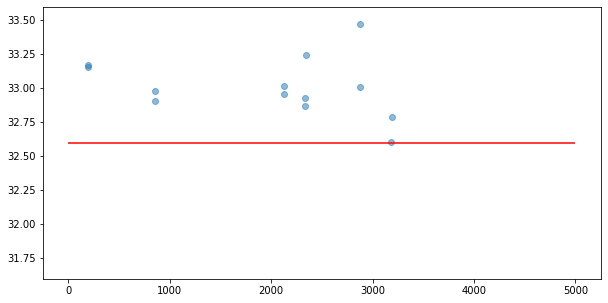

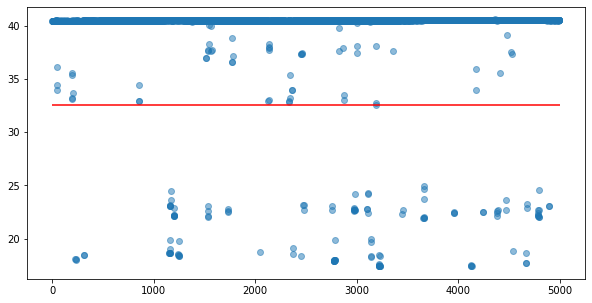

In [19]:
azimuth = int(np.around((4900/100)/0.2))
laser = 20
ts = aggregated_maps_sorted_temp[:,azimuth,np.where(np.sort(theta) == theta[laser])[0][0]].copy()
thred = get_threshold(ts)
# ts = ts[ts!=200]
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
plt.hlines(thred,0,len(ts),color = 'r')
plt.ylim(thred - 1, thred + 1)
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
# plt.hlines(thred,0,5000,color = 'r')
plt.hlines(thred,0,len(ts),color = 'r')
# plt.ylim(thred - 1, thred + 1)
plt.show()

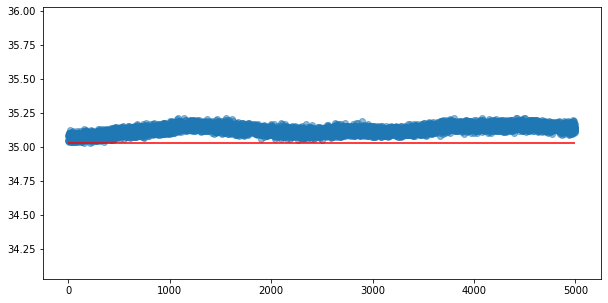

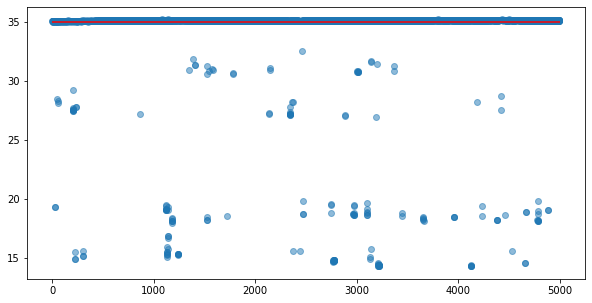

In [20]:
azimuth = int(np.around((1979/100)/0.2))
laser = 20
ts = aggregated_maps_sorted_temp[:,azimuth,np.where(np.sort(theta) == theta[laser])[0][0]].copy()
thred = get_threshold(ts)
# ts = ts[ts!=200]
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
plt.hlines(thred,0,len(ts),color = 'r')
plt.ylim(thred - 1, thred + 1)
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
# plt.hlines(thred,0,5000,color = 'r')
plt.hlines(thred,0,len(ts),color = 'r')
# plt.ylim(thred - 1, thred + 1)
plt.show()

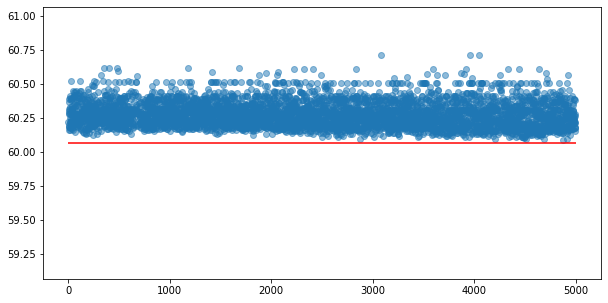

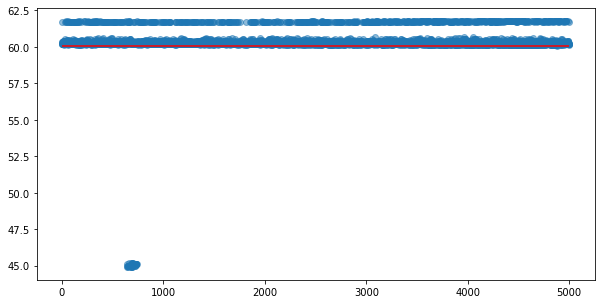

In [21]:
azimuth = int(np.around((12067/100)/0.2))
laser = 20
ts = aggregated_maps_sorted_temp[:,azimuth,np.where(np.sort(theta) == theta[laser])[0][0]].copy()
thred = get_threshold(ts)
# ts = ts[ts!=200]
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
plt.hlines(thred,0,len(ts),color = 'r')
plt.ylim(thred - 1, thred + 1)
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
# plt.hlines(thred,0,5000,color = 'r')
plt.hlines(thred,0,len(ts),color = 'r')
# plt.ylim(thred - 1, thred + 1)
plt.show()

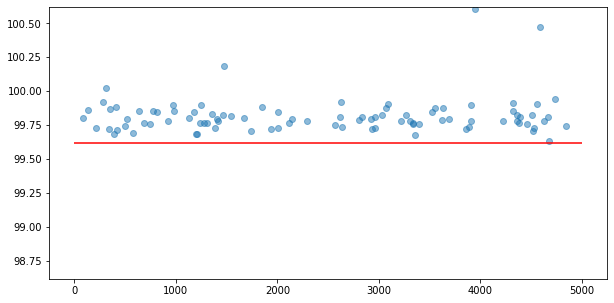

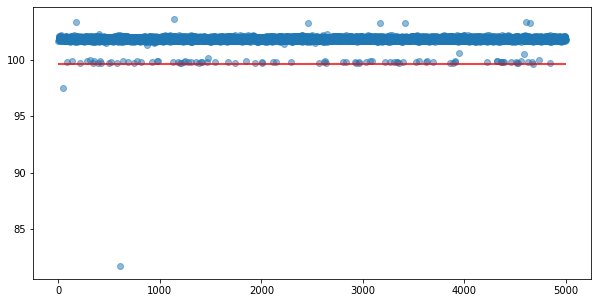

In [113]:
azimuth = int(np.around((13836/100)/0.2))
laser = 20
ts = aggregated_maps_sorted_temp[:,azimuth,np.where(np.sort(theta) == theta[laser])[0][0]].copy()
thred = get_threshold(ts)
# ts = ts[ts!=200]
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
plt.hlines(thred,0,len(ts),color = 'r')
plt.ylim(thred - 1, thred + 1)
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
# plt.hlines(thred,0,5000,color = 'r')
plt.hlines(thred,0,len(ts),color = 'r')
# plt.ylim(thred - 1, thred + 1)
plt.show()

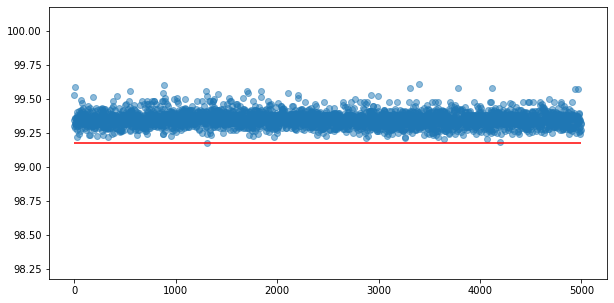

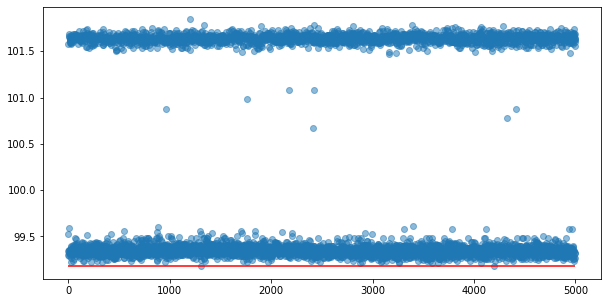

In [104]:
azimuth = int(np.around((13821/100)/0.2))
laser = 20
ts = aggregated_maps_sorted_temp[:,azimuth,np.where(np.sort(theta) == theta[laser])[0][0]].copy()
thred = get_threshold(ts)
# ts = ts[ts!=200]
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
plt.hlines(thred,0,len(ts),color = 'r')
plt.ylim(thred - 1, thred + 1)
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
# plt.hlines(thred,0,5000,color = 'r')
plt.hlines(thred,0,len(ts),color = 'r')
# plt.ylim(thred - 1, thred + 1)
plt.show()

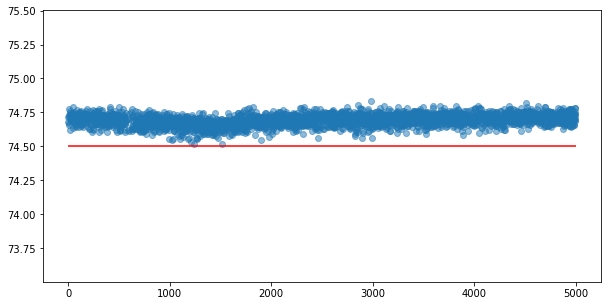

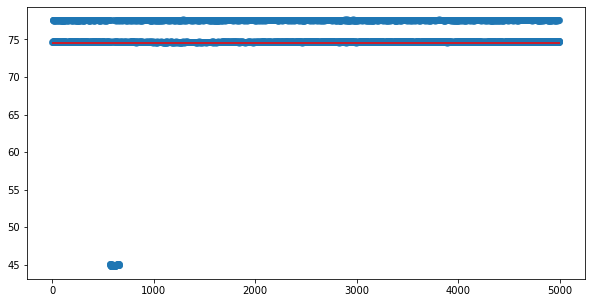

In [105]:
azimuth = int(np.around((12940/100)/0.2))
laser = 15
ts = aggregated_maps_sorted_temp[:,azimuth,np.where(np.sort(theta) == theta[laser])[0][0]].copy()
thred = get_threshold(ts)
# ts = ts[ts!=200]
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
plt.hlines(thred,0,len(ts),color = 'r')
plt.ylim(thred - 1, thred + 1)
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
# plt.hlines(thred,0,5000,color = 'r')
plt.hlines(thred,0,len(ts),color = 'r')
# plt.ylim(thred - 1, thred + 1)
plt.show()

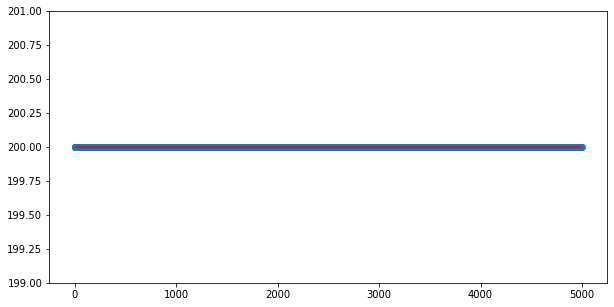

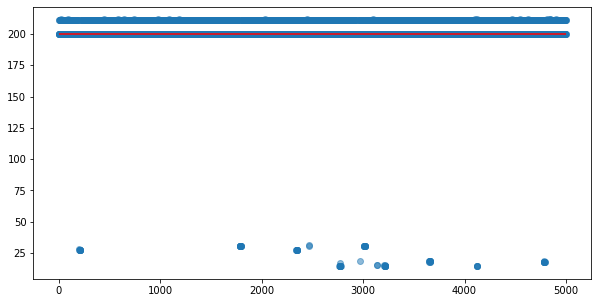

In [106]:
azimuth = 47
laser = 26
ts = aggregated_maps_sorted_temp[:,azimuth,laser].copy()
thred = get_threshold(ts)
# ts = ts[ts!=200]
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
plt.hlines(thred,0,len(ts),color = 'r')
plt.ylim(thred - 1, thred + 1)
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
# plt.hlines(thred,0,5000,color = 'r')
plt.hlines(thred,0,len(ts),color = 'r')
# plt.ylim(thred - 1, thred + 1)
plt.show()

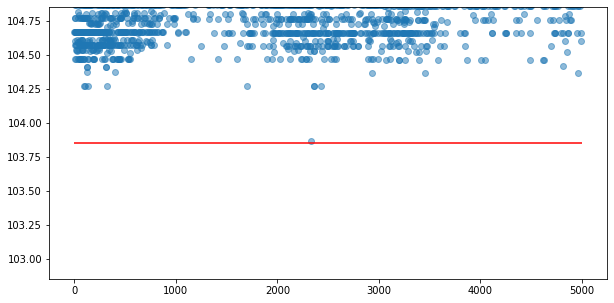

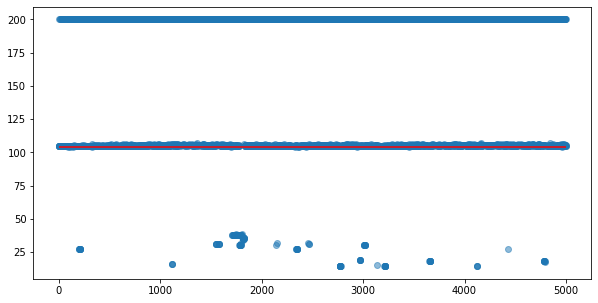

In [110]:
ts = aggregated_maps_sorted_temp[:,64,22].copy()
# ts = ts[ts!=200]
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[laser])[0][0]]
thred = get_threshold(ts)

plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
plt.hlines(thred,0,len(ts),color = 'r')
plt.ylim(thred - 1, thred + 1)
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(ts)),ts,alpha = 0.5)
# thred = threshold_map[azimuth,np.where(np.sort(theta) == theta[13])[0][0]]
# plt.hlines(thred,0,5000,color = 'r')
plt.hlines(thred,0,len(ts),color = 'r')
# plt.ylim(thred - 1, thred + 1)
plt.show()

In [114]:
frq = np.zeros((1800,32))
for i in tqdm(range(aggregated_maps_sorted_temp.shape[1])):
    for j in range(aggregated_maps_sorted_temp.shape[2]):
        ts = aggregated_maps_sorted_temp[:,i,j].copy()
        thred = threshold_map[i,j]
        frq[i,j] = (ts<thred).sum()/len(ts)
        

In [115]:
np.where(frq>0.7)

(array([], dtype=int64), array([], dtype=int64))

(array([5.5261e+04, 1.6040e+03, 1.3300e+02, 8.3000e+01, 9.9000e+01,
        1.0200e+02, 9.8000e+01, 7.9000e+01, 8.8000e+01, 5.3000e+01]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 <BarContainer object of 10 artists>)

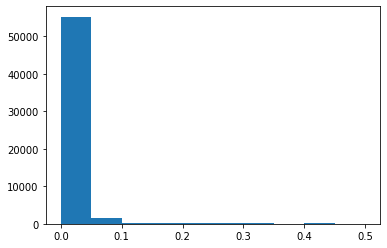

In [116]:
plt.hist(frq.flatten())

In [117]:
np.save(r'E:\lidar\op3\threshold_map.npy',threshold_map)

In [26]:
def cal_gradient(point_a,aggrated_map,searching_tatoo_table,threshold_map):
    available_neighbors = find_undetected_neighbors(point_a,searching_tatoo_table)
    if len(available_neighbors) == 0 :
        return 0
    else:
        ts_a = aggrated_map[:,point_a[0],point_a[1]].copy()
        pulse_a = (ts_a<threshold_map[point_a[0],point_a[1]])*1
        if pulse_a.sum() == 0:
            return 0
        sum_matching_degree = []
        for i in range(len(available_neighbors)):
            ts_b = aggrated_map[:,available_neighbors[i][0],available_neighbors[i][1]].copy()
            pulse_b = (ts_b<threshold_map[available_neighbors[i][0],available_neighbors[i][1]])*1
            if pulse_b.sum() == 0:
                continue
            convolved_s = np.convolve(pulse_a,pulse_b[::-1])
            max_matching = convolved_s.max()/pulse_a.sum() 
            # the maximum matching degree 
            matching_shift = np.abs(convolved_s.argmax() - len(pulse_a) + 1)
            # the ts shift of maximum matching degree
            if matching_shift<2:
                sum_matching_degree.append(max_matching)
        return np.sum(sum_matching_degree)
    
    

In [119]:
searching_tatoo_table = get_initial_tattoo_table(aggregated_maps_sorted,threshold_map)
with tqdm(total = searching_tatoo_table.shape[0]*searching_tatoo_table.shape[1]) as pbar:
    pbar.update((searching_tatoo_table == 1).sum())
    gradient_map = np.zeros_like(searching_tatoo_table)
    for row in range(searching_tatoo_table.shape[0]):
        for col in range(searching_tatoo_table.shape[1]):
            if searching_tatoo_table[row,col] != 1:
                pbar.update(1)
                gradient_map[row,col] = cal_gradient(np.array([row,col]),aggregated_maps_sorted_temp,searching_tatoo_table,threshold_map)

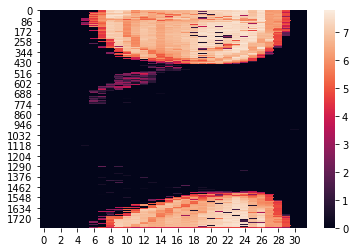

In [120]:
sns.heatmap(gradient_map)
plt.show()

(array([41850.,   630.,   560.,   466.,   411.,   761.,  1322.,  1940.,
         5604.,  4056.]),
 array([0.        , 0.77884615, 1.55769231, 2.33653846, 3.11538462,
        3.89423077, 4.67307692, 5.45192308, 6.23076923, 7.00961538,
        7.78846154]),
 <BarContainer object of 10 artists>)

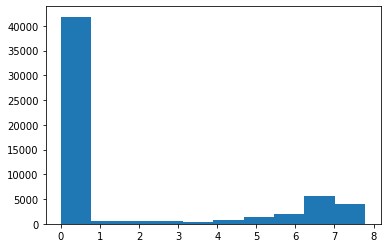

In [121]:
plt.hist(gradient_map.flatten())

<AxesSubplot:>

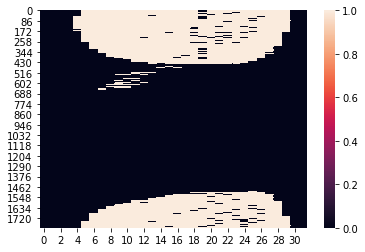

In [235]:
sns.heatmap(binary_map)

In [123]:
rbg_red = np.array([204,47,107]) # red
rbg_green = np.array([27,168,34]) # green
rbg_blue = np.array([0,0,255]) # blue

In [124]:
def gen_filtered_frame(td_freq_map,binary_map,threshold_map):
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(td_freq_map.shape[0]):
        longitudes = np.sort(theta)*np.pi / 180
        latitudes = i*0.2* np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        # 0 refers to background
#         (binary_map[i]==1) & 
        Label =  (td_freq_map[i]<threshold_map[i]).astype('int')     
        Xs.append(X)
        Ys.append(Y)
        Zs.append(Z)
        Labels.append(Label)
    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels)
    color_labels = np.zeros((len(Labels),3))
    color_labels[Labels == 1] = rbg_blue
    color_labels[Labels == 0] = rbg_red
    pcd = op3.geometry.PointCloud()
    pcd.points = op3.utility.Vector3dVector(np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1))
    pcd.colors = op3.utility.Vector3dVector(color_labels/255)
    return pcd
                

In [125]:
np.save(r'E:\lidar\op3\gradient_map.npy',gradient_map)

In [132]:
gradient_map = np.load(r'E:\lidar\op3\gradient_map.npy')
threshold_map = np.load(r'E:\lidar\op3\threshold_map.npy')
binary_map = gradient_map.copy()
binary_map[binary_map < 4] = 0 # low homogeneity
binary_map[binary_map >= 4] = 1 #high homo

In [133]:
pcds = []
for i in tqdm(range(len(aggregated_maps_sorted_temp))):
    pcd = gen_filtered_frame(aggregated_maps_sorted_temp[i],binary_map,threshold_map)
    op3.io.write_point_cloud("E:\lidar\op3\pcds\{}.pcd".format(i), pcd)
    pcds.append(pcd)

## Visualization 

In [107]:
def save_view_point(pcd, filename):
    vis = op3.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()  # user changes the view and press "q" to terminate
    param = vis.get_view_control().convert_to_pinhole_camera_parameters()
    op3.io.write_pinhole_camera_parameters(filename, param)
    vis.destroy_window()


def load_view_point(pcd, filename):
    vis = op3.visualization.Visualizer()
    vis.create_window()
    ctr = vis.get_view_control()
    param = op3.io.read_pinhole_camera_parameters(filename)
    vis.add_geometry(pcd)
    ctr.convert_from_pinhole_camera_parameters(param)
    vis.run()
    vis.destroy_window()

In [109]:
save_view_point(pcds[205],r'E:\lidar\op3\view_point.json')